In [42]:
from deeplearning_check import *

In [1]:
IMG_SIZE = 150
NUM_EPOCHS = 8
NUM_CLASSES = 2
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 
opt =  tf.optimizers.Adam()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5591509021038979577
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 109283371761961424
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9883535296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6453876104243684170
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4880960706912045425
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def create_model():
  #resnet_weights_path = '/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5'
  #resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

  #weigths = weights=resnet_weights_path ->none
  resnet = ResNet50(include_top=False, pooling='avg', weights = None)
  #resnet.summary()
  my_new_model = Sequential()
  my_new_model.add(resnet)
  my_new_model.layers[0].trainable = True
  my_new_model.add(Dense(NUM_CLASSES, activation='softmax')) #dense 3, NUM_CLASSES = 3

  # Say no to train first layer (ResNet) model. It is already trained
    
  opt =  tf.optimizers.Adam()
   #opt바꾼거 확인해
  my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_new_model

In [3]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=False,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\train",
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\validation",
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps = 1 
            #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return H, model, train_generator,validation_generator

In [4]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [5]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [6]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [7]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

In [8]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1]- 600 # 위치
    cv2.putText(frame, class_string, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [9]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [10]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        print(c)
        print(confidence)
        txt += label_dict[c]
        txt += '['+ str(confidence) +']'
    return txt
    # txt = neutral[0.38]

In [11]:
def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        print('pred_vec')
        print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        pc = pred_vec.argmax()
        pred_class.append( (pc, confidence) )

        if pred_class:
            txt = get_display_string(pred_class, label_dict)
            print('최종txt' +txt)       
            frame = draw_prediction( frame, txt )
            #print('pred_class')
            #print(pred_class)
            #print('label_dict')
            #print(label_dict)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
        writer.write(frame)
        
    vs.release()
    writer.release()

#### Training

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


Found 5938 images belonging to 2 classes.
Found 742 images belonging to 2 classes.
Epoch 1/8
78/77 [==============================] - 26s 337ms/step - loss: 0.7521 - accuracy: 0.7267 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 2/8
78/77 [==============================] - 25s 319ms/step - loss: 0.1998 - accuracy: 0.9106 - val_loss: 0.0555 - val_accuracy: 1.0000
Epoch 3/8
78/77 [==============================] - 25s 322ms/step - loss: 0.1532 - accuracy: 0.9330 - val_loss: 0.0222 - val_accuracy: 1.0000
Epoch 4/8
78/77 [==============================] - 25s 321ms/step - loss: 0.1346 - accuracy: 0.9454 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/8
78/77 [==============================] - 25s 321ms/step - loss: 0.0887 - accuracy: 0.9619 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/8
78/77 [==============================] - 26s 330ms/step - loss: 0.1098 - accuracy: 0.9566 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/8
78/77 [==============================] - 25

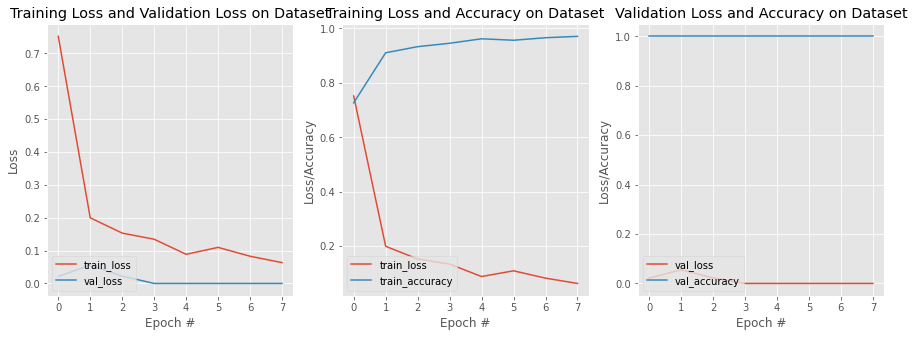

In [13]:
H, trained_model,train_generator,validation_generator = train_model(model)
label_dict= get_label_dict(train_generator)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.save('/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5')

In [16]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.save('/content/drive/MyDrive/fragile/Classification/0712up_fragile_resnet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc',\
                      tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')\
                          ,tf.keras.metrics.FalsePositives(name='false_positives')\
                          ,tf.keras.metrics.FalseNegatives(name='false_negatives')])

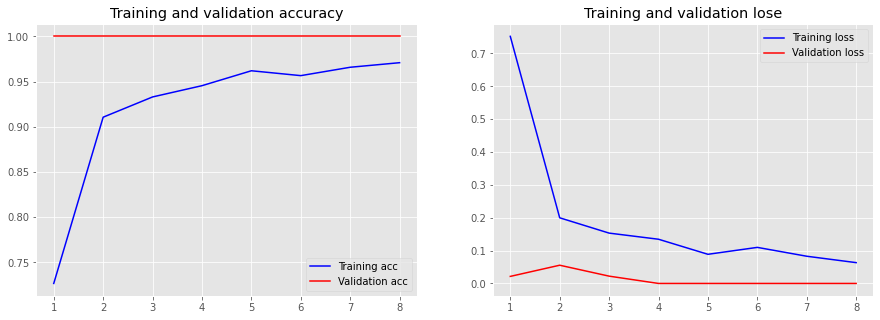

In [32]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

### evaluate

In [41]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(train_generator, batch_size=TRAIN_BATCH_SIZE)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

78/78 [==============================] - 25s 323ms/step - loss: 0.1115 - acc: 0.9606 - precision: 0.9606 - recall: 0.9606 - false_positives: 234.0000 - false_negatives: 234.0000
loss: 0.111, accuracy: 0.961, precision: 0.961, recall: 0.961, false_positive: 234.000, false_negative: 234.000, f1score: 0.961


In [57]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(test_generator, batch_size=50)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

10/10 [==============================] - 3s 284ms/step - loss: 0.1183 - acc: 0.9597 - precision: 0.9597 - recall: 0.9597 - false_positives: 30.0000 - false_negatives: 30.0000
loss: 0.118, accuracy: 0.960, precision: 0.960, recall: 0.960, false_positive: 30.000, false_negative: 30.000, f1score: 0.960


In [58]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(validation_generator, batch_size=77)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

742/742 [==============================] - 7s 9ms/step - loss: 0.1142 - acc: 0.9569 - precision: 0.9569 - recall: 0.9569 - false_positives: 32.0000 - false_negatives: 32.0000
loss: 0.114, accuracy: 0.957, precision: 0.957, recall: 0.957, false_positive: 32.000, false_negative: 32.000, f1score: 0.957


### test set

In [52]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=False,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )

In [53]:
test_generator = data_generator_with_aug.flow_from_directory(
            "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\test",
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')

Found 744 images belonging to 2 classes.


In [62]:
test_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Deeplearning\\Datasets\\org_dir\\test"
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 744 images belonging to 2 classes.


In [82]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(test_set, batch_size=50)
print('\nloss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

24/24 [==============================] - ETA: 0s - loss: 0.6968 - acc: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 352.0000 - false_negatives: 352.00 - 0s 19ms/step - loss: 0.6968 - acc: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 372.0000 - false_negatives: 372.0000

loss: 0.697, accuracy: 0.500, precision: 0.500, recall: 0.500, false_positive: 372.000, false_negative: 372.000, f1score: 0.500


In [64]:
real_test_dir = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign"
test_datagen = ImageDataGenerator(rescale = 1./255)
real_test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (100, 100),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 744 images belonging to 2 classes.


In [65]:
_loss, _acc, _precision, _recall, _fp, _fn  = model.evaluate(real_test_set, batch_size=50)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, false_positive: {:.3f}, false_negative: {:.3f}, f1score: {:.3f}'\
      .format(_loss, _acc, _precision, _recall, _fp, _fn, f1score(_recall, _precision)))

24/24 [==============================] - 0s 20ms/step - loss: 0.6968 - acc: 0.5000 - precision: 0.5000 - recall: 0.5000 - false_positives: 372.0000 - false_negatives: 372.0000
loss: 0.697, accuracy: 0.500, precision: 0.500, recall: 0.500, false_positive: 372.000, false_negative: 372.000, f1score: 0.500


### save

In [60]:
/pwd

'C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\classification'

In [59]:
model.save('[0721]data_generator_resnet50.h5')

# Save model with json format 
model_json = model.to_json() 
with open("[0721]data_generator_resnet50.json", "w") as json_file:
    json_file.write(model_json)
    
# Save weight with h5 format
model.save_weights("[0721]data_generator_resnet50_weight.h5")
print("Saved model to disk")

Saved model to disk


### Real pic test

In [66]:
import os
test_img_path = "C:\\Users\\yukir\\Documents\\Monicas_workspace\\Sign detection\\fragile sign"
file_list = os.listdir(test_img_path)
file_list.sort
print(len(file_list))
list_file=[]
for i in file_list:
    list_file.append(test_img_path+i)
list_file.sort()
len(list_file)

18


18

In [68]:
file_name=[]
for i in list_file:
    name = i.split("\\")[-1]
    file_name.append(name)
file_name

['fragile signblankstock180501065.jpg',
 'fragile signgrunge-fragile-box-sign-with-arrow-up-on-piece-of-carton-for-logistics-or-cargo-and-alphabet-means-this-way-up-handle-with-care-vector-stencil-font-2DKJT9W.jpg',
 'fragile signimages (1).jpg',
 'fragile signimages.jpg',
 'fragile signresized_logistic_sign_test (10).jpg',
 'fragile signresized_logistic_sign_test (11).jpg',
 'fragile signresized_logistic_sign_test (12).jpg',
 'fragile signresized_logistic_sign_test (13).jpg',
 'fragile signresized_logistic_sign_test (14).jpg',
 'fragile signresized_logistic_sign_test (15).jpg',
 'fragile signresized_logistic_sign_test (16).jpg',
 'fragile signresized_logistic_sign_test (3).jpg',
 'fragile signresized_logistic_sign_test (4).jpg',
 'fragile signresized_logistic_sign_test (5).jpg',
 'fragile signresized_logistic_sign_test (6).jpg',
 'fragile signresized_logistic_sign_test (7).jpg',
 'fragile signresized_logistic_sign_test (8).jpg',
 'fragile signresized_logistic_sign_test (9).jpg']

In [70]:
test_df = pd.DataFrame({'file_name':file_name})
nbsamples=test_df.shape[0]
nbsamples

18

In [46]:
batch_size=15

In [47]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=False,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5])
                               

In [73]:
test_generator = data_generator_with_aug.flow_from_directory(
            real_test_dir,
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')

Found 18 images belonging to 1 classes.


In [71]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_accuracy", 
                        patience = 2, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)
                        
callbacks = [earlystop, learning_rate_reduction]

In [74]:
predict=model.predict_generator(test_generator, 
                                steps=nbsamples/TEST_BATCH_SIZE, 
                                callbacks=callbacks)
                                
test_df['category']=np.argmax(predict, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [77]:
test_df['category']=test_df['category'].replace({0:'up',1:"fragile"})
ex_df=test_df.sample(n=1).reset_index(drop=True)
ex_df

,file_name,category
0,fragile signresized_logistic_sign_test (12).jpg,up


In [92]:
test_df.head(7)

,file_name,category
0,fragile signblankstock180501065.jpg,fragile
1,fragile signgrunge-fragile-box-sign-with-arrow...,up
2,fragile signimages (1).jpg,fragile
3,fragile signimages.jpg,up
4,fragile signresized_logistic_sign_test (10).jpg,up
5,fragile signresized_logistic_sign_test (11).jpg,fragile
6,fragile signresized_logistic_sign_test (12).jpg,up


In [93]:
test_df.category.value_counts()

fragile    10
up          8
Name: category, dtype: int64